In [1]:
import random
from itertools import combinations

from tqdm.notebook import tqdm

from config import config as cfg
from rl_trading_framework import *

In [2]:
# from rl_validation
%store -r selected_pair_names
batch_size_test = len(selected_pair_names)
print(selected_pair_names)

['GD-NVDA', 'GILD-INTC', 'BAC-TSLA', 'GM-TSLA', 'CAT-NVDA', 'GE-TSLA', 'AVGO-AXP', 'AIG-TSLA', 'F-T', 'BA-MRK', 'SCHW-TMUS', 'MET-NVDA', 'GE-GM', 'GOOG-HD', 'AMGN-MA', 'BA-MDLZ', 'CVX-GM']


In [3]:
tickers = set()
for pair in selected_pair_names:
    ticker = pair.split('-')
    tickers.update(ticker)
tickers = list(tickers)
# print(tickers)

pair_indices = []
ticker_to_index = {ticker: index for index, ticker in enumerate(tickers)}
for pair in selected_pair_names:
    two_tickers = pair.split('-')
    idx1, idx2 = ticker_to_index[two_tickers[0]], ticker_to_index[two_tickers[1]]
    pair_indices.append((idx1, idx2))
    
if len(pair_indices) % 2 != 0:
    random_pair = random.choice(pair_indices)
    pair_indices.append(random_pair)

all_pairs = list(combinations(range(len(tickers)), 2))

In [4]:
price_data_all = get_data_torch(tickers, cfg['test_start'], cfg['test_end'], cfg['start_time'], 
                                 cfg['end_time'], cfg['multiplier'], cfg['data_freq'])
price_data_all = price_data_all.to(cfg['device'])

Getting data: 100%|██████████████████████████████████████| 25/25 [00:09<00:00,  2.73it/s]


In [5]:
# instantiate model
state_encoding_model = StateEncodingModel(cfg['device'], input_dim=8, lstm_hidden_dim=cfg['lstm_hidden_dim'], num_layers=cfg['lstm_num_layers']).to(cfg['device'])
trading_policy_model = TradingPolicyModel(cfg['lstm_hidden_dim'], cfg['mlp_hidden_dim'], cfg['action_dim']).to(cfg['device'])
trading_agent = TradingAgent(state_encoding_model, trading_policy_model)
env = TradingEnvironment(state_encoding_model,cfg['reg_rolling_window'], cfg['portfolio_settings'], cfg['action_dim'], cfg['n_of_gpu'])

# load model paras
model_folder_path = get_model_folder(cfg, version=1)
load_model_paras(state_encoding_model, model_folder_path, 'state_encoding_model', eval_gpu='single')
load_model_paras(trading_policy_model, model_folder_path, 'policy_model_model', eval_gpu='single')

In [6]:
# agent trading
env.update_data(price_data_all)
state_encoding_model.reset_state(batch_size_test)
trading_agent.reset()
env.reset(pair_indices=pair_indices)
ob_t = env.update_observation()
done = False

trajectory = []
action_history = []
port_value_history = [np.array(env.port_value.cpu())]
quantity_history = [[(float(y), float(x)) for y, x in zip(env.y_quantity, env.x_quantity)]]

with tqdm(total=env.period_len-cfg['reg_rolling_window'], desc='agent trading') as pbar:
    while not done:     # for t in range(reg_rolling_window, env.period_len):
        
        encoded_state = state_encoding_model(ob_t)
        env.norm_port_value = (env.port_value / env.bt_settings['initial_cash']).unsqueeze(1)
        action = trading_agent.choose_action(encoded_state, env.norm_port_value, cfg['method_in_test'])
        reward, ob_t, done = env.step(action)       # reward not used for now
        action_history.append(np.array(action.cpu()))
        port_value_history.append(np.array(env.port_value.cpu()))
        quantity_history.append([(float(y), float(x)) for y, x in zip(env.y_quantity, env.x_quantity)])
        trajectory.append((encoded_state, action, reward))      # trajectory not used for now
        pbar.update(1)

action_history = np.array(action_history)
port_value_history = np.array(port_value_history) / env.bt_settings['initial_cash']
quantity_history = np.array(quantity_history)
pair_names = [f"{tickers[i]}-{tickers[j]}" for i, j in env.pair_indices]

agent trading:   0%|          | 0/191 [00:00<?, ?it/s]

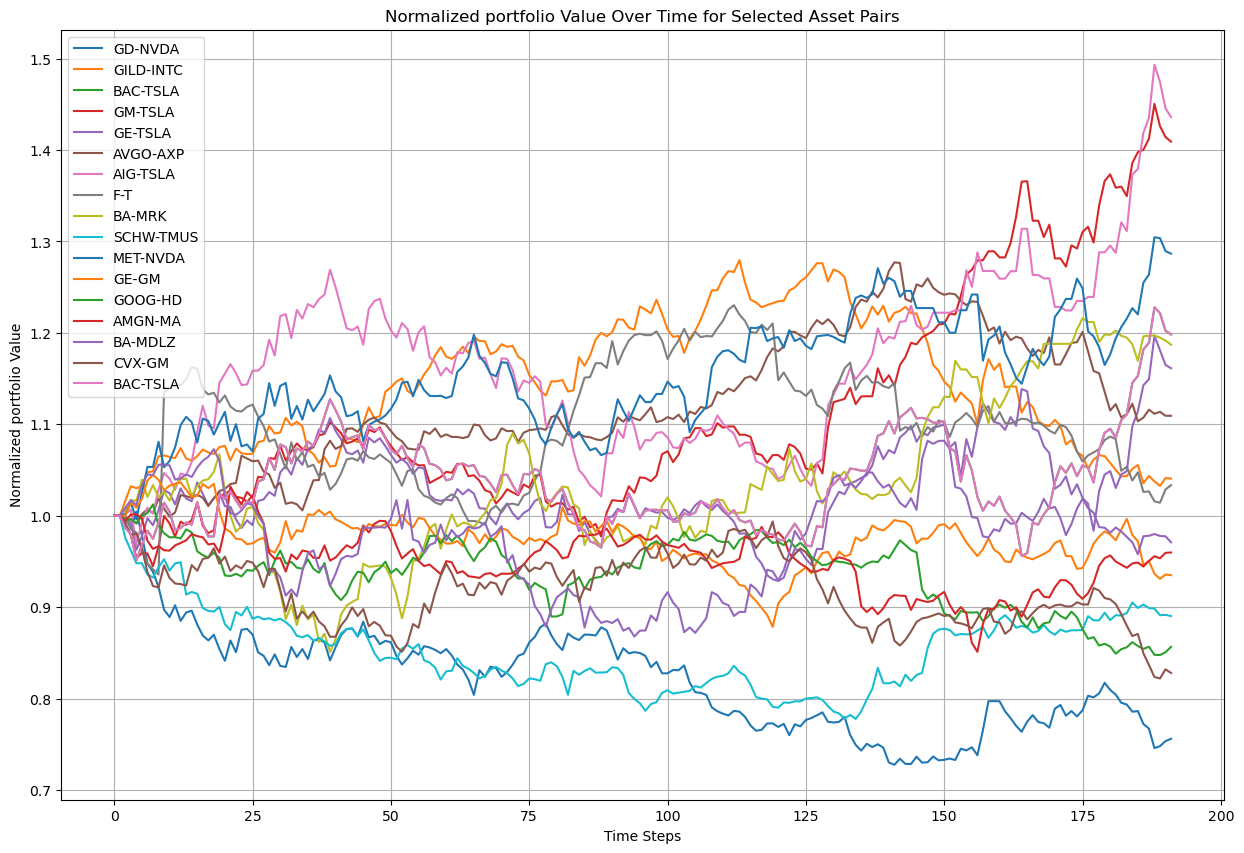

In [7]:
num_quantiles = 1
top_n_pairs_each_quantile = len(selected_pair_names)     # plot all
selected_pair_names = plot_and_return_top_pairs(num_quantiles, top_n_pairs_each_quantile, port_value_history, pair_names)

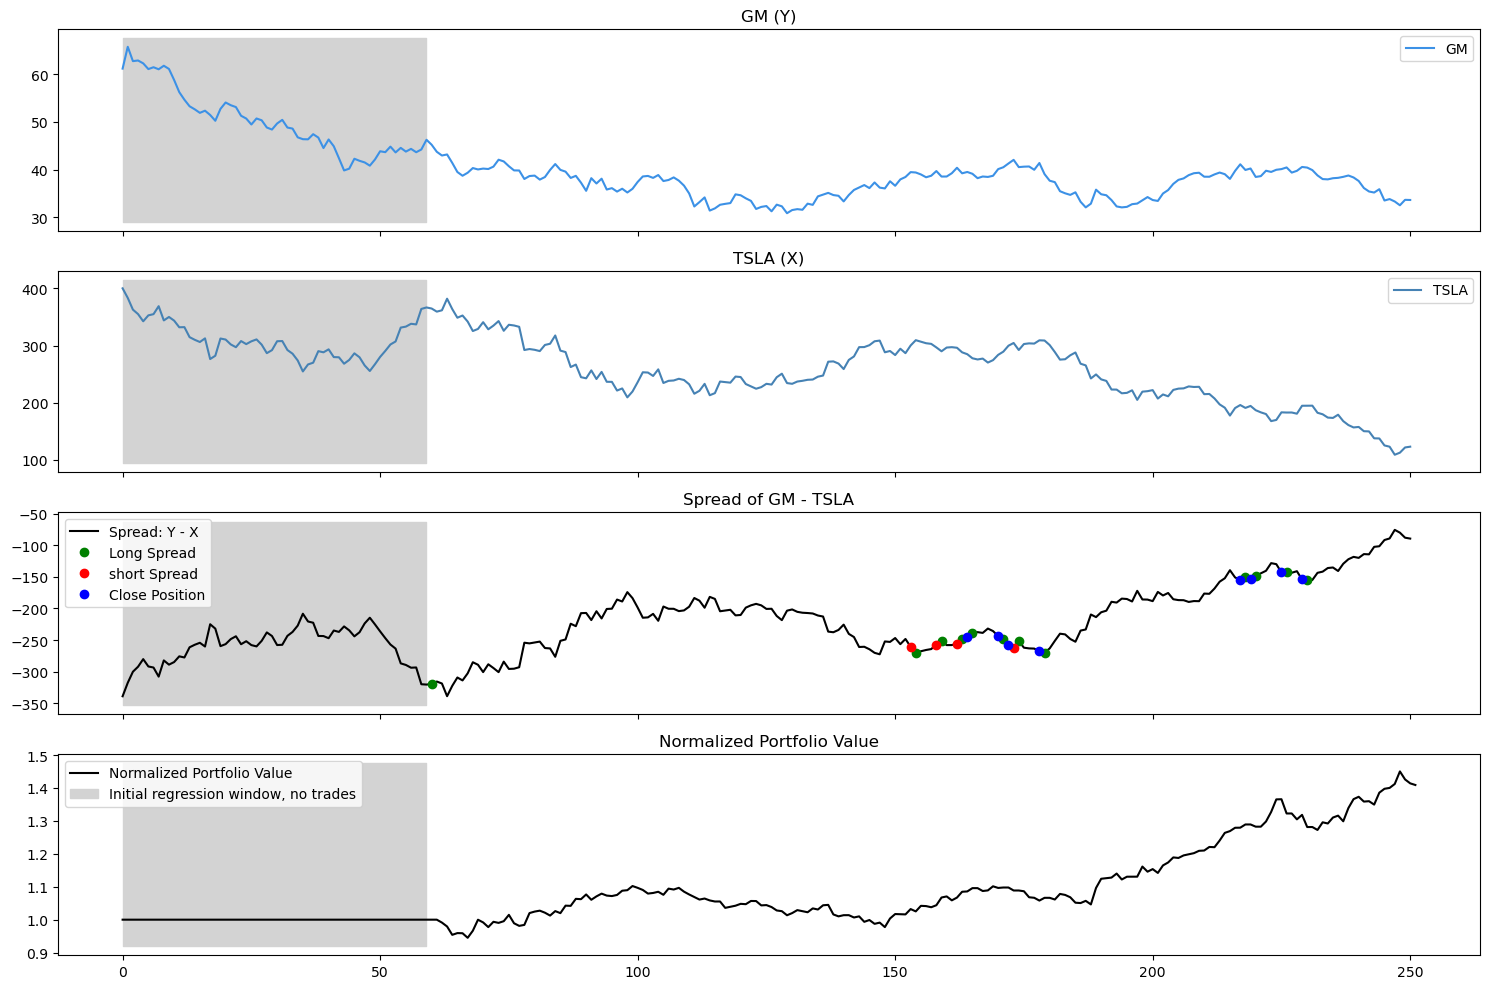

In [11]:
# %matplotlib notebook
%matplotlib inline
pair_to_plot = 'GM-TSLA'
plot_a_pair(pair_to_plot, tickers, env.pair_indices, price_data_all.cpu().numpy(), cfg['reg_rolling_window'], port_value_history, action_history)

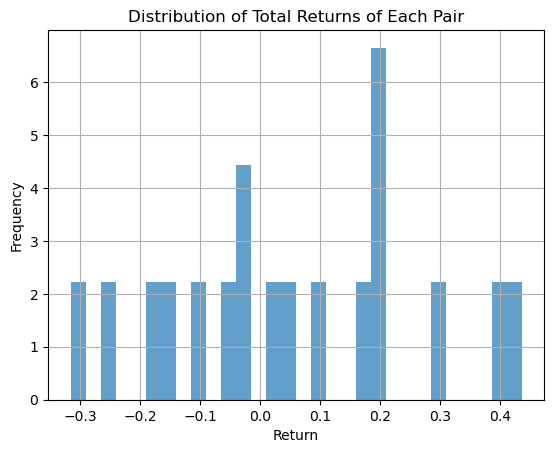

In [9]:
# choices are 'total return of each pair', 'across time steps', and 'all'
plot_return_distribution(port_value_history, choice='total return of each pair', bins=30)

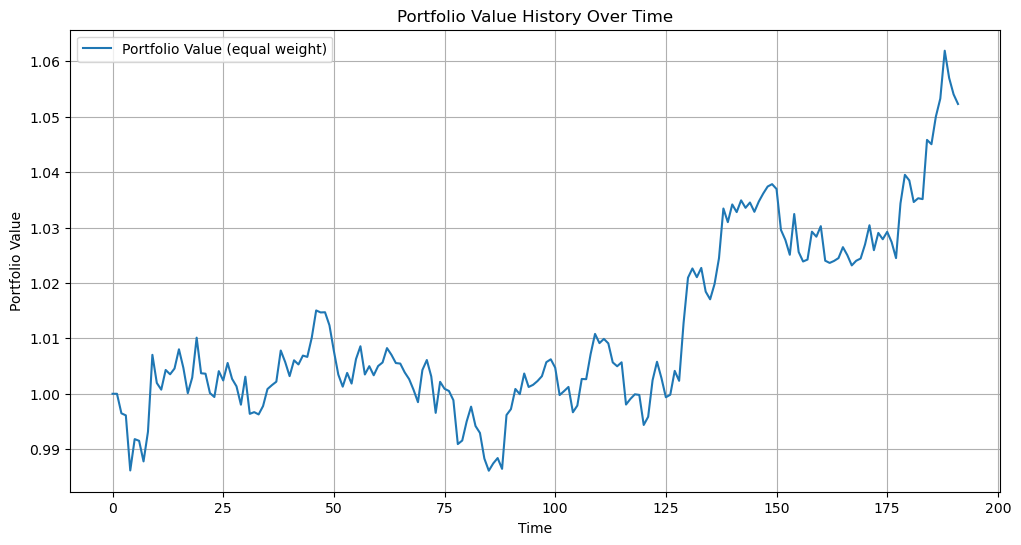

In [10]:
portfolio_value = port_value_history.mean(axis=1)

# Plot the portfolio value history
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value (equal weight)')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value History Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plot_return_distribution(port_value_history, choice='across time steps', bins=30)

In [ ]:
plot_return_distribution(port_value_history, choice='all', bins=30)